In [1]:
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
import umap
import pickle
import tqdm

from gptenrichment import genemap, enrichr

library = enrichr.get_library("GO_Biological_Process_2021")
library = genemap.remove_long_lists(library, 2000)
genes = list(set([element for sublist in library.values() for element in sublist]))
lib1, lib2 = genemap.split_lists(library, factor=3, overlap=True)



/Users/maayanlab/Library/Python/3.9/lib/python/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Users/maayanlab/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
keys = list(library.keys())
random.shuffle(keys)
len(keys)

training_library = {}
testing_library = {}

for i,k in enumerate(keys):
    if i < 4000:
        training_library[k] = library[k]
    else:
        testing_library[k] = library[k]


In [18]:
def leave_one_out_lists(input_dict, factor=1):
    dict1 = {}
    dict2 = {}
    for key, value in input_dict.items():
        for i in range(factor):
            random.shuffle(value)
            dict1[key+str(i)] = value[:-1]
            dict2[key+str(i)] = value[-1]
    return dict1, dict2

def create_data(library, limit=np.nan):
    #lib1, lib2 = genemap.split_lists(library, factor=3)
    lib1, lib2 = leave_one_out_lists(library, factor=3)

    embedding1 = genemap.embed_library(lib1, progress=True)
    embedding2 = genemap.embed_library(lib2, progress=True)
    true_samples = []
    false_samples = []
    
    for k in range(embedding1.shape[0]):
        true_samples.append(embedding1.iloc[k,:] - embedding2.iloc[k,:])

    for i in range(100000):
        r1 = random.randint(0,embedding1.shape[0]-1)
        r2 = random.randint(0,embedding1.shape[0]-1)
        false_samples.append(embedding1.iloc[r1,:] - embedding2.iloc[r2,:])
    
    true_samples = np.array(true_samples)
    false_samples = np.array(false_samples)

    X = np.concatenate((true_samples, false_samples), axis=0)
    X = pd.DataFrame(X, index=range(X.shape[0]))
    y = np.array([1]*true_samples.shape[0] + [0]*false_samples.shape[0])
    return X,y



In [19]:
train_X, train_y = create_data(training_library)

100%|██████████| 240/240 [06:34<00:00,  1.65s/it] 


In [20]:
X_test, y_test = create_data(testing_library)

100%|██████████| 123/123 [05:09<00:00,  2.52s/it]


In [21]:
model = LGBMRegressor(seed=42)
mod = model.fit(X_train, y_train)

In [22]:
y_pred = model.predict(X_test)

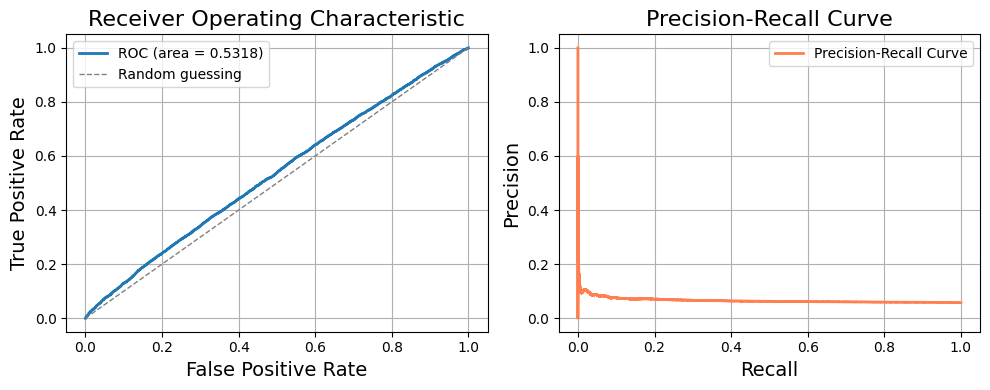

In [23]:

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Create a new figure with two subplots, side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot ROC curve
ax1.plot(fpr, tpr, lw=2, label='ROC (area = %0.4f)' % roc_auc)
ax1.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray', label='Random guessing')
ax1.set_title('Receiver Operating Characteristic', fontsize=16)
ax1.set_xlabel('False Positive Rate', fontsize=14)
ax1.set_ylabel('True Positive Rate', fontsize=14)
ax1.legend()
ax1.grid(True)

# Plot Precision-Recall curve
ax2.plot(recall, precision, lw=2, label='Precision-Recall Curve',c="coral")
ax2.set_title('Precision-Recall Curve', fontsize=16)
ax2.set_xlabel('Recall', fontsize=14)
ax2.set_ylabel('Precision', fontsize=14)
ax2.legend()
ax2.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

